ZZ TODO:

-CNN/RNN with doc2vec

# <font color='purple'>Predicting Song Genres Using Lyrical Analysis</font>

<i>Authors</i>: Zachary Zalman, Jacob Mannix

<i>Date</i>: 16 May 2020

### Load In Needed Materials and Functions

In [78]:
import pandas as pd
from datetime import datetime
from tqdm import tqdm_notebook as tqdm
import ast
import re
from statistics import mean

import numpy as np

import spacy

import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

from sklearn import utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from nltk.tokenize.treebank import TreebankWordDetokenizer

import tensorflow as tf

import keras

from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from tensorflow.keras import initializers

import matplotlib.pyplot as plt

spacy.prefer_gpu()

False

In [79]:
# define a function to turn the string of lyric tokens into a list of lyric tokens
def format_column(text):

    lyrics_list = ast.literal_eval(text)
    
    result = []
    
    # loop through every lyric to remove the newline character
    for entry in lyrics_list:

        if entry != '\n ':
            result.append(entry)
        else:
            continue
    
    return result

### First Time Creation of Tokens

In [ ]:
# load in the lyrics data set
first_df = pd.read_csv("lyrics.csv")

In [ ]:
# create a song id number by renaming the index
first_df.rename(columns={"index":"song_id"}, inplace=True)
first_df.shape

In [ ]:
first_df.dropna(subset=['lyrics'], inplace=True)
first_df.shape

In [ ]:
# split the dataframe
info = first_df[["song_id", "song", "year", "artist", "genre"]]
lyrics = first_df[["song_id", "lyrics"]]

print(info.columns)
print(lyrics.columns)

In [ ]:
# load the spaCy object with the english corpus
nlp = spacy.load("en_core_web_md")

Creating a tokenizer pipeline

In [ ]:
# define the lemmatizer function
def lemmatizer(doc):
    # remove the PRON (which are pronouns after lemming)
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)

def remove_punct(doc):
    # remove punctuation -> Use token.text to return strings, needed for Gensim.
    doc = [token.text for token in doc if token.is_punct != True]
    return doc


# add_pipe adds the function to the tokenizer
nlp.add_pipe(lemmatizer,name='lemmatizer',after='ner')
nlp.add_pipe(remove_punct, name="punct", last=True)

In [ ]:
# get the column of lyrics
doc = lyrics.lyrics
doc

In [ ]:
# check to see if any lyrics are missing
doc.isna().sum()

In [ ]:
# laptop time to run = 
# desktop time to run = 

doc_list = []

# go through each song
for doc in tqdm(doc):
    
    # tokenize the document
    pr = nlp(doc)
    
    # add it to the list
    doc_list.append(pr)

In [ ]:
# check a list of tokens
doc_list[0]

In [ ]:
# turn the list into a series, then turn it into a dataframe
temp = pd.DataFrame(pd.Series(doc_list), columns=["tokens"])

# reset the indices of the original df and the token df
temp.reset_index(drop=True, inplace=True)
first_df.reset_index(drop=True, inplace=True)

# merge the tokens df onto the original df using the indicies
df_with_tokens = pd.merge(first_df, temp, left_index=True, right_index=True)

In [ ]:
# save the df
# df_with_tokens.to_csv("lyrics_with_tokens.txt", sep="|", index=False)

## Processing the Tokens

In [95]:
# load in the dat set if it has already been created
df = pd.read_csv("lyrics_with_tokens.txt", sep="|")

In [96]:
df = df[df.genre != "Not Available"]
df = df[df.genre != "Other"]
df.genre.value_counts()
df

,song_id,song,year,artist,genre,lyrics,tokens
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu...","['oh', 'baby', 'how', 'do', '\n ', 'know', 'be..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see...","['playin', 'everything', 'so', 'easy', '\n ', ..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...,"['if', 'search', '\n ', 'for', 'tenderness', '..."
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote...","['oh', 'oh', 'oh', 'oh', 'oh', 'oh', '\n ', 'v..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po...","['party', 'the', 'people', 'the', 'people', 't..."
...,...,...,...,...,...,...,...
266552,362232,who-am-i-drinking-tonight,2012,edens-edge,Country,"I gotta say\nBoy, after only just a couple of ...","['got', 'to', 'say', '\n ', 'boy', 'after', 'o..."
266553,362233,liar,2012,edens-edge,Country,I helped you find her diamond ring\nYou made m...,"['help', 'find', 'diamond', 'ring', '\n ', 'ma..."
266554,362234,last-supper,2012,edens-edge,Country,Look at the couple in the corner booth\nLooks ...,"['look', 'at', 'the', 'couple', 'in', 'the', '..."
266555,362235,christ-alone-live-in-studio,2012,edens-edge,Country,When I fly off this mortal earth\nAnd I'm meas...,"['when', 'fly', 'off', 'this', 'mortal', 'eart..."


In [97]:
df = df.sample(frac=0.05, random_state=1)
df.reset_index(inplace=True, drop=True)
df

,song_id,song,year,artist,genre,lyrics,tokens
0,211037,i-miss-you,2004,boyz-ii-men,Pop,Thought I heard your voice yesterday\nWhen I t...,"['think', 'hear', 'voice', 'yesterday', '\n ',..."
1,132404,n-l-y-h,2007,deathrow,Metal,"The alarm clock rings, I open my eyes\nAnd wat...","['the', 'alarm', 'clock', 'ring', 'open', 'eye..."
2,290018,had-to-grow-up,2005,aselin-debison,Pop,Another day late for the bus again\nA single m...,"['another', 'day', 'late', 'for', 'the', 'bus'..."
3,59126,pharaoh,2007,chroming-rose,Metal,"no fucking rounds can hit him\nno, no chain ma...","['no', 'fucking', 'round', 'can', 'hit', '\n '..."
4,93619,you,2010,elise-estrada,Pop,Unfair\nUnreal\nI wanna tell my heart it's a q...,"['unfair', '\n ', 'unreal', '\n ', 'wanna', 't..."
...,...,...,...,...,...,...,...
11866,316020,fall-down,2012,diggy-simmons,Hip-Hop,Who said enough was ever enough?\nWill we let ...,"['who', 'say', 'enough', 'be', 'ever', 'enough..."
11867,318289,baby-of-gold,2001,das-pop,Pop,baby of gold/ baby of gold/ never grow old/ ke...,"['baby', 'of', 'gold/', 'baby', 'of', 'gold/',..."
11868,165918,sunshine-after-the-rain,2006,elkie-brooks,Pop,Everywhere I go\nI see a face we used to know\...,"['everywhere', 'go', '\n ', 'see', 'a', 'face'..."
11869,336003,the-greatest-thing,2011,cher,Rock,"(Cher)\nI don't know why you hurt inside,\nOr ...","['Cher', '\n ', 'do', 'not', 'know', 'why', 'h..."


Define the lyric list and genre list

In [98]:
# get the tokens of the lyrics, and turn it into a list
lyrics_list = df['tokens']
lyrics_list = lyrics_list.to_list()

lyr_list = []

# loop through all of the songs, and get a list of the tokens from each string
for lyr in tqdm(lyrics_list):
    temp = ast.literal_eval(lyr)
    lyr_list.append(temp)

del lyrics_list

len(lyr_list)

C:\Users\blitz\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


11871

In [99]:
# get the genres and turn it into a list
genre_list = df['genre']
gen_list = genre_list.to_list()

del genre_list

len(gen_list)

11871

Turn tokens list into a string of lyrics

In [100]:
result3 = []

# loop through all the songs in the dataset
for song in tqdm(lyr_list):
    
    result = []
    result2 = []
    tmp = []
    
    # loop through all the lines in a song
    for word in song:
    
        # if the token is a newline, replace it with a period. otherwise append the token to the list
        if word != '\n ':
            tmp.append(word)
        else:
            tmp.append('.')
            result.append(tmp)
            tmp = []
        
    # loop through all the lines again
    for index, value in enumerate(result):

        # lowercase everyhing and turn into a string
        temp_lower = [x.lower() for x in value]
        temp = " ".join(temp_lower)
        
        # skip the line if it is a verse indicator
        if re.search(r"verse [1-9]", temp):
            continue
            
        # remove any song markers from the data (these are single item lists with values that indicate song parts)
        if temp != 'chorus' and temp != 'intro' and temp != 'outro hook' and temp != 'bridge' and temp != 'pre hook' and temp != 'hook':
            result2.append(temp_lower)
    
    # append the processed song to the list
    result3.append(result2)

C:\Users\blitz\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [101]:
result3[0]

[['think', 'hear', 'voice', 'yesterday', '.'],
 ['when', 'turn', 'around', 'to', 'say', '.'],
 ['that', 'love', 'baby', '.'],
 ['realize', 'be', 'just', 'mind', '.'],
 ['play', 'trick', 'on', '.'],
 ['and', 'seem', 'cold', 'lately', 'at', 'night', '.'],
 ['and', 'try', 'to', 'sleep', 'with', 'the', 'light', 'on', '.'],
 ['every', 'time', 'the', 'phone', 'ring', '.'],
 ['pray', 'to', 'god', 'be', '.'],
 ['and', 'just', 'can', 'not', 'believe', '.'],
 ['that', 'be', 'through', '.'],
 ['miss', '.'],
 ['there', 'be', 'no', 'other', 'way', 'to', 'say', '.'],
 ['and', 'can', 'not', 'deny', '.'],
 ['miss', '.'],
 ['be', 'so', 'easy', 'to', 'see', '.'],
 ['miss', 'and', '.'],
 ['be', 'turn', 'over', 'this', 'time', '.'],
 ['have',
  'really',
  'change',
  'mind',
  'about',
  'each',
  'other',
  "'s",
  'love',
  '.'],
 ['all', 'the', 'feeling', 'that', 'use', 'to', 'share', '.'],
 ['refuse', 'to', 'believe', '.'],
 ['that', 'do', 'not', 'care', '.'],
 ['miss', '.'],
 ['there', 'be', 'no', '

In [102]:
lyr_list_final = []

# loop through all the songs
for song in tqdm(result3):
    
    lyr_list_str = []
    
    # loop through each line in the song, and merge all the tokens together
    for i in range(len(song)):
        temp = TreebankWordDetokenizer().detokenize(song[i])
        lyr_list_str.append(temp)
    
    # turn the list of strings into one string
    lyr_list_str = ", ".join(lyr_list_str)
    
    # replace the list element separator with a period to show line end
    lyr_list_str = lyr_list_str.replace('.,', '')
    
    # append the lyrics string to the list
    lyr_list_final.append(lyr_list_str)

C:\Users\blitz\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [103]:
lyr_list_final[7765]

'every man need a woman in life every man need a lady by side someone to support through the tough time through the fight someone who can lift up when fall when be hurt will care and when cry will be there through the rain will lend the sun when all else fail can count on say can count on cause will love will love will love will love will love will love will love will love will love oh will love oh will love will love will love will love will love will love will love every man need someone who understand precious as life and the struggle of a man rich or for poor will be there till the end till death do part or when god call when be hurt will care and when cry will be there through the rain will lend the sun when all else fail can count on cause will love will love will love will love will love will love will love will love will love oh will love oh will love will love will love.'

In [104]:
# create a dataframe of the lyrics and genre from the two lists
df2 = pd.DataFrame(lyr_list_final)
df2['genre'] = gen_list
df2.columns = ('lyrics', 'genre')
df2

,lyrics,genre
0,think hear voice yesterday when turn around to...,Pop
1,the alarm clock ring open eye and watch the ye...,Metal
2,another day late for the bus again a single mo...,Pop
3,no fucking round can hit no no chain make can ...,Metal
4,unfair unreal wanna tell heart be a quick stea...,Pop
...,...,...
11866,who say enough be ever enough will let make th...,Hip-Hop
11867,baby of gold/ baby of gold/ never grow old/ ke...,Pop
11868,everywhere go see a face use to know pass a pl...,Pop
11869,cher do not know why hurt inside or what be sa...,Rock


In [134]:
# delete unneeded variables
# del lyr_list_final
# del gen_list
# del lyr_list_str
# del result3
# del result2
# del result
# del lyr_list

## Vanilla NN With Doc2Vec

In [33]:
# shuffle the df before splitting
df = df.sample(frac=1.0, random_state=99).reset_index(inplace=True, drop=True)
df

,song_id,song,year,artist,genre,lyrics,tokens
0,270033,destiny,2006,glenn-hughes,Rock,Look what you've done\nYou think that you're t...,"['look', 'what', 'have', 'do', '\n ', 'think',..."
1,232176,gonna-rain-today,2007,gary-moore,Rock,"2 3 4\nOutside, the sun is shining\nIt's feeli...","['2', '3', '4', '\n ', 'outside', 'the', 'sun'..."
2,66229,shake-rattle-bang-your-head,2007,the-adicts,Rock,"Hey you, I'll tell you what to do\nI'll tell y...","['hey', 'will', 'tell', 'what', 'to', 'do', '\..."
3,298665,overnight,2007,bouncing-souls,Rock,We walk the house of life\nSee the things that...,"['walk', 'the', 'house', 'of', 'life', '\n ', ..."
4,245451,all-this-time,2015,fox-stevenson,Electronic,"[Pre-Chorus]\nI don't mind,\n'Cause this is so...","['Pre', 'Chorus', '\n ', 'do', 'not', 'mind', ..."
...,...,...,...,...,...,...,...
47480,135532,batty-boyz,2009,doom,Hip-Hop,oh shoot - get a load of that fruit\nin thigh ...,"['oh', 'shoot', 'get', 'a', 'load', 'of', 'tha..."
47481,30993,changes,2010,gentleman,Electronic,No more time to waste\nAnd you know just wat t...,"['no', 'more', 'time', 'to', 'waste', '\n ', '..."
47482,21633,done-done,2009,frankmusik,Electronic,Tell me are you better?\nNow you put your life...,"['tell', 'be', 'well', '\n ', 'now', 'put', 'l..."
47483,202638,sway,2013,blue-october,Rock,We sway\nGrabbed her by the hips and hand\nThe...,"['sway', '\n ', 'grab', 'by', 'the', 'hip', 'a..."


In [34]:
# perform a test/train split on the data
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [35]:
# turn the training data into tagged documents
# train_tagged = train.apply(lambda r: TaggedDocument(words=format_column(r['tokens']), tags=[r.genre]), axis=1)
# train_tagged

train_tagged = [TaggedDocument(words=format_column(_d.lower()), tags=[str(i)]) for i, _d in enumerate(train.tokens)]
train_tagged

[TaggedDocument(words=['expansion', 'of', 'the', 'ever', 'increase', 'universe', 'thin', 'down', 'imperfect', 'picture', 'and', 'certainty', 'of', 'the', 'tangible', 'existence', 'trickle', 'between', 'finger', 'enter', 'the', 'center', 'of', 'the', 'point', 'physical', 'reality', 'die', 'give', 'birth', 'to', 'the', 'new', 'order', 'negate', 'all', 'that', 'have', 'ever', 'be', 'say', 'for', 'good', 'so', 'what', 'be', 'attract', 'by', 'the', 'gravity', 'of', 'the', 'black', 'hole', 'veil', 'by', 'the', 'faith', 'in', 'word', 'proud', 'of', 'the', 'promise', 'immortality', 'hysteria', 'at', 'the', 'moment', 'of', 'sudden', 'illumination', 'will', 'ring', 'with', 'countless', 'scream', 'unite', 'in', 'a', 'sneer', 'come', 'from', 'the', 'empty', 'throne'], tags=['0']),
 TaggedDocument(words=['do', 'know', 'what', 'mean', 'to', 'be', 'bury', 'in', 'the', 'seam', 'to', 'run', 'as', 'thick', 'as', 'thief', 'when', 'have', 'a', 'sure', 'thing', 'do', 'not', 'mess', 'with', 'success', 'when

In [36]:
# turn the test data into tagged documents
# test_tagged = test.apply(lambda r: TaggedDocument(words=format_column(r['tokens']), tags=[r.genre]), axis=1)
# test_tagged

test_tagged = [TaggedDocument(words=format_column(_d.lower()), tags=[str(i)]) for i, _d in enumerate(test.tokens)]
test_tagged

[TaggedDocument(words=['walk', 'in', 'just', 'like', 'smoke', 'with', 'a', 'little', 'come', 'on', 'come', 'on', 'come', 'on', 'in', 'walk', 'well', 'come', 'on', 'have', 'be', 'waitin', 'be', 'waitin', 'for', 'move', 'well', 'be', 'makin', 'so', 'tell', 'baby', 'can', 'shake', 'if', 'can', 'move', 'with', 'ya', 'will', 'let', 'take', 'will', 'be', 'down', 'on', 'knee', 'screamin', 'take', 'take', 'take', 'take', 'be', 'your', 'have', 'never', 'feel', 'so', 'out', 'of', 'control', 'do', 'not', 'even', 'know', 'what', 'be', 'do', 'to', 'come', 'on', 'and', 'do', 'to', "don'tcha", 'stop', 'come', 'on', 'come', 'on', 'come', 'on', 'little', 'rabbit', 'show', 'where', 'get', 'cause', 'know', 'get', 'a', 'habit'], tags=['0']),
 TaggedDocument(words=['paint', 'sand', 'and', 'makeshift', 'hand', 'take', 'round', 'and', 'round', 'horizon', 'clear', 'will', 'soon', 'be', 'near', 'be', 'walk', 'on', 'the', 'ground', 'have', 'be', 'round', 'the', 'corner', 'sink', 'all', 'the', 'doubt', 'in', 'si

In [37]:
train_tagged[967]

TaggedDocument(words=['tupac', 'shakur', 'try', 'to', 'plant', 'something', 'in', 'the', 'conrete', "why'knowhatimean", 'if', 'grow', 'and', 'the', 'and', 'the', 'rose', 'petal', 'get', 'all', 'kind', 'of', 'scratch', 'and', 'mark', 'not', 'gon', 'say', 'damn', 'look', 'at', 'all', 'the', 'scratch', 'and', 'mark', 'on', 'the', 'rose', 'that', 'grow', 'from', 'concrete', 'gon', 'be', 'like', 'damn', 'a', 'rose', 'grow', 'from', 'the', 'concrete', 'same', 'thing', 'with', "why'knahmean", 'grow', 'out', 'of', 'all', 'of', 'this', 'instead', 'of', 'sayin', 'damn', 'do', 'this', 'do', 'this', 'just', 'be', 'like', 'damn', 'grow', 'out', 'of', 'that', 'come', 'out', 'of', 'that', 'that', 'be', 'what', 'should', 'say', "why'knowhatimean", 'all', 'the', 'trouble', 'to', 'survive', 'and', 'make', 'good', 'out', 'of', 'the', 'dirty', 'nasty', "why'knowhahatimean", 'unbelievable', 'lifestyle', 'give', 'be', 'just', 'tryin', 'to', 'make', 'something', 'nikki', 'giovanni', 'when', 'no', 'one', 'eve

Creating the model

In [66]:
# create the parameters of the Doc2Vec model
d2v_model = Doc2Vec(vector_size=400,
                window=5, 
                alpha=.025, 
                min_alpha=0.00025, 
                min_count=2, 
                dm=1, 
                workers=8)

# build the vocab of the model
d2v_model.build_vocab(train_tagged)

In [67]:
# define the epochs count
epochs = range(20)

# loop through each epoch
for epoch in epochs:
    
    print(f'Epoch {epoch+1}')
    
    # train the model on the training data
    d2v_model.train(train_tagged,
                    total_examples=d2v_model.corpus_count,
                    epochs=d2v_model.epochs)
    
    # decrease the learning rate
    d2v_model.alpha -= 0.00025
    
    # fix the learning rate, no decay
    d2v_model.min_alpha = d2v_model.alpha
     
d2v_model.save('lyricsDoc2Vec.model')

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20


In [ ]:
# load in the model if its already trained
# d2v_model = Doc2Vec.load('lyricsDoc2Vec.model')

Creation of test/train X and y arrays

In [69]:
# run doc2vec on the traininng data
X_train = np.array([d2v_model.docvecs[str(i)] for i in range(len(train_tagged))])

# encode the genres as numbers (factors)
labelencoder_y_1 = LabelEncoder()
y_train = labelencoder_y_1.fit_transform(train['genre'])

In [70]:
# run doc2vec on the test data
X_test = np.array([d2v_model.infer_vector(test_tagged[i][0]) for i in range(len(test_tagged))])

# encode the genres as numbers (factors)
labelencoder_y_1 = LabelEncoder()
y_test = labelencoder_y_1.fit_transform(test['genre'])

In [71]:
X_train[555]

array([ 1.53349495e+00,  1.37566894e-01,  2.51310080e-01, -1.31534708e+00,
        1.50283420e+00,  6.27098680e-01, -5.23021519e-01,  8.10865819e-01,
        1.71618208e-01, -3.90618406e-02, -1.13170683e+00, -1.80483177e-01,
       -4.16790754e-01,  4.95632052e-01,  1.29474008e+00, -2.50229776e-01,
        5.71361161e-04,  1.63369417e+00,  2.93645263e-01,  5.38291574e-01,
        2.06775561e-01, -1.24860287e+00, -4.24818546e-01,  1.05746806e+00,
       -4.49265987e-01, -1.52922139e-01,  7.05846250e-01, -3.79749119e-01,
        6.64596975e-01,  6.42069042e-01,  8.89168799e-01,  8.56120408e-01,
       -1.06546581e+00, -6.99286759e-01,  1.70669329e+00,  1.68010139e+00,
       -9.62799430e-01, -6.63094699e-01,  1.48405421e+00, -9.79591787e-01,
       -1.07742083e+00,  1.19576502e+00, -1.52107012e+00, -2.52770156e-01,
       -1.83189675e-01,  1.52187124e-01, -1.47017390e-01, -6.64674461e-01,
        1.31557202e+00, -7.75949001e-01, -3.81703854e-01, -1.30189866e-01,
        1.27410936e+00, -

VNN

In [72]:
# use Keras functional API to make a easier-to-read flow of the network

inputs = keras.Input(shape=(400,))

x = layers.Dense(256, activation="relu")(inputs)
x = layers.Dropout(0.2)(x)

x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(10, activation='softmax')(x)

vnn_model = keras.Model(inputs=inputs, outputs=outputs, name="nn_d2v_model")

vnn_model.summary()

Model: "nn_d2v_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 500)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 256)               128256    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)               

In [73]:
vnn_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

history = vnn_model.fit(X_train,
                        y_train, 
                        batch_size=64, 
                        epochs=2,
#                         validation_split=0.2,
                        validation_data=(X_test, y_test))

Train on 33239 samples, validate on 14246 samples
Epoch 1/2
33239/33239 [==============================] - 2s 49us/step - loss: 2.0043 - accuracy: 0.4576 - val_loss: 2.0045 - val_accuracy: 0.4567
Epoch 2/2
33239/33239 [==============================] - 1s 44us/step - loss: 2.0026 - accuracy: 0.4586 - val_loss: 2.0045 - val_accuracy: 0.4567


## RNN and CNN With Embedding Layer

This set of networks uses df2, not df -> see end of <b>Processing the Tokens</b> code

#### Regular CNN

In [74]:
# encode the genres as numbers (factors)
labelencoder_y_1 = LabelEncoder()
y = labelencoder_y_1.fit_transform(df2['genre'])

# perform a test/train split on the data
X_train, X_test, y_train, y_test = train_test_split(df2['lyrics'], y, test_size=0.2, random_state=42)

# use Keras tokenizer to tokenize the words and give a numerical index to the word
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

# find out the size of the vocabulary and save it as a variable
vocab_size = len(tokenizer.word_index) + 1
vocab_size

# use the tokenizer on the train and test data
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# find the average song length (by token count) by looping through each one and adding the length to a list
longest = []
for i in X_train:
    longest.append(len(i))
mean(longest)

# define the max length of the vectors as near this average
maxlen = 200

# pad the sequences if they don't reach the average length
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[  80   39    8    6   18   18   10    8   18   10   20  252   20   80
   39    8    6   18   52   26   31    8   56   10   20   20   20   20
   80   61  285   38    8   60    1   16    3   56   61  285   38    8
   60 2374    3   18  100   28   24    1    5   27  841   20   20   19
   80   39    8    6   18   91  243    1  452   18   10    1   97  252
  252   97  361   80   39    8    6   18   52   26   31    8   56   10
   20   20   20   20  897    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [ ]:
# start = datetime.now()

# def cnn_embedding_model(num_filters, kernel_size, activation_1, activation_2, dense_nodes, optimizer):
#     model = Sequential()
    
#     model.add(layers.Embedding(vocab_size, output_dim=100, input_length=maxlen))
    
#     model.add(layers.Conv1D(num_filters, kernel_size, activation=activation_1))
    
#     model.add(layers.GlobalMaxPooling1D())
   
#     model.add(layers.Dense(dense_nodes, activation=activation_2))
    
#     model.add(layers.Dense(10, activation='softmax'))
    
#     model.compile(optimizer=optimizer,
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'])
    
#     return model

# param_grid = dict(num_filters=[32, 64, 128],
#                   kernel_size=[3, 5, 7],
#                   activation_1=['relu', 'tanh'], 
#                   activation_2=['relu', 'tanh'],
#                   dense_nodes=[64, 100, 128],
#                   optimizer=['adam', 'RMSprop'])

# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import RandomizedSearchCV

# # Main settings
# epochs = 5
# batch_size = 32
# maxlen = 200

# cnn_model = KerasClassifier(build_fn=cnn_embedding_model,
#                         epochs=epochs, 
#                         batch_size=batch_size,
#                         verbose=False)

# grid = RandomizedSearchCV(estimator=cnn_model, param_distributions=param_grid, cv=5, verbose=1, n_iter=5)

# grid_result = grid.fit(X_train, y_train)

# # Evaluate testing set
# test_accuracy = grid.score(X_test, y_test)

# print("Overall Run Time:", datetime.now()-start)

In [75]:
cnn_model = Sequential()
cnn_model.add(layers.Embedding(input_dim=vocab_size, 
                               output_dim=100, 
                               input_length=maxlen))

cnn_model.add(layers.Conv1D(256, 5, activation='relu'))
cnn_model.add(layers.GlobalMaxPooling1D())
cnn_model.add(layers.Dense(64, activation='relu'))

cnn_model.add(layers.Dense(10, activation='softmax'))

cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          13169200  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 196, 256)          128256    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_36 (Dense)             (None, 10)                650       
Total params: 13,314,554
Trainable params: 13,314,554
Non-trainable params: 0
_________________________________________________________________


In [76]:
history_cnn = cnn_model.fit(X_train, y_train,
                        epochs=3,
                        verbose=1,
#                         validation_split=0.2,
                        validation_data=(X_test, y_test),
                        batch_size=10)

loss, accuracy = cnn_model.evaluate(X_train, y_train, verbose=1)

print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = cnn_model.evaluate(X_test, y_test, verbose=1)

print("Testing Accuracy:  {:.4f}".format(accuracy))

# list all data in history
print(history_cnn.history.keys())
# summarize history for accuracy
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

C:\Users\blitz\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 37988 samples, validate on 9497 samples
Epoch 1/3
37988/37988 [==============================] - 684s 18ms/step - loss: 1.3695 - accuracy: 0.5524 - val_loss: 1.2848 - val_accuracy: 0.5768
Epoch 2/3
 2460/37988 [>.............................] - ETA: 11:07 - loss: 1.1660 - accuracy: 0.6154

KeyboardInterrupt: 

#### Regular RNN

In [158]:
# encode the genres as numbers (factors)
labelencoder_y_1 = LabelEncoder()
y = labelencoder_y_1.fit_transform(df2['genre'])

# perform a test/train split on the data
X_train, X_test, y_train, y_test = train_test_split(df2['lyrics'], y, test_size=0.2, random_state=42)

# use Keras tokenizer to tokenize the words and give a numerical index to the word
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

# find out the size of the vocabulary and save it as a variable
vocab_size = len(tokenizer.word_index) + 1
vocab_size

# use the tokenizer on the train and test data
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# find the average song length (by token count) by looping through each one and adding the length to a list
longest = []
for i in X_train:
    longest.append(len(i))
mean(longest)

# define the max length of the vectors as near this average
maxlen = 200

# pad the sequences if they don't reach the average length
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[1273  185    1  185   91 1292   15   36    2  184  117  849   42   15
 1273    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [159]:
rnn_model = Sequential()
rnn_model.add(layers.Embedding(input_dim=vocab_size, 
                               output_dim=100, 
                               input_length=maxlen))

rnn_model.add(layers.SpatialDropout1D(0.2))

rnn_model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))

rnn_model.add(layers.Flatten())

rnn_model.add(layers.Dense(10, activation='softmax'))

rnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

rnn_model.summary()

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_67 (Embedding)     (None, 200, 100)          5606000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_133 (Dense)            (None, 10)                1010      
Total params: 5,687,410
Trainable params: 5,687,410
Non-trainable params: 0
_________________________________________________________________


In [157]:
history_rnn = rnn_model.fit(X_train, y_train,
                        epochs=5,
                        verbose=1,
#                         validation_split=0.1,
                        validation_data=(X_test, y_test),
                        batch_size=32)

loss, accuracy = rnn_model.evaluate(X_train, y_train, verbose=1)

print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = rnn_model.evaluate(X_test, y_test, verbose=1)

print("Testing Accuracy:  {:.4f}".format(accuracy))

# list all data in history
print(history_rnn.history.keys())
# summarize history for accuracy
plt.plot(history_rnn.history['accuracy'])
plt.plot(history_rnn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'rnn_model' is not defined

#### RNN and CNN Combined

In [105]:
# encode the genres as numbers (factors)
labelencoder_y_1 = LabelEncoder()
y = labelencoder_y_1.fit_transform(df2['genre'])

# perform a test/train split on the data
X_train, X_test, y_train, y_test = train_test_split(df2['lyrics'], y, test_size=0.2, random_state=42)

# use Keras tokenizer to tokenize the words and give a numerical index to the word
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

# find out the size of the vocabulary and save it as a variable
vocab_size = len(tokenizer.word_index) + 1
vocab_size

# use the tokenizer on the train and test data
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# find the average song length (by token count) by looping through each one and adding the length to a list
longest = []
for i in X_train:
    longest.append(len(i))
mean(longest)

# define the max length of the vectors as near this average
maxlen = 200

# pad the sequences if they don't reach the average length
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[1273  185    1  185   91 1292   15   36    2  184  117  849   42   15
 1273    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [134]:
vocab_size

56060

Two-stream approach

In [135]:
# use Keras functional API to make a easier-to-read flow of the network

inputs = keras.Input(shape=(200,))

embed = layers.Embedding(vocab_size,100)(inputs)

x = layers.Conv1D(256, 5, activation='relu')(embed)
x = layers.GlobalMaxPooling1D()(x)

y = layers.SpatialDropout1D(0.2)(embed)
y = layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(y)
y = layers.Flatten()(y)

merge_layer = layers.concatenate([x, y])
z = layers.Dense(256, activation="relu")(merge_layer)
z = layers.Dense(128, activation="relu")(z)

outputs = layers.Dense(10, activation='softmax')(z)

model_rnncnn1 = keras.Model(inputs=inputs, outputs=outputs, name="cnn_rnn_split_model")

model_rnncnn1.summary()

Model: "cnn_rnn_split_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 200, 100)     5606000     input_24[0][0]                   
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 196, 256)     128256      embedding_13[0][0]               
__________________________________________________________________________________________________
spatial_dropout1d_3 (SpatialDro (None, 200, 100)     0           embedding_13[0][0]               
________________________________________________________________________________

In [136]:
model_rnncnn1.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

history_rnncnn1 = model_rnncnn1.fit(X_train,
                                    y_train, 
                                    batch_size=64, 
                                    epochs=2,
#                                     validation_split=0.2,
                                    validation_data=(X_test, y_test))

loss, accuracy = model_rnncnn1.evaluate(X_train, y_train, verbose=1)

print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model_rnncnn1.evaluate(X_test, y_test, verbose=1)

print("Testing Accuracy:  {:.4f}".format(accuracy))

# list all data in history
print(history_rnncnn1.history.keys())
# summarize history for accuracy
plt.plot(history_rnncnn1.history['accuracy'])
plt.plot(history_rnncnn1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_rnncnn1.history['loss'])
plt.plot(history_rnncnn1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

C:\Users\blitz\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9496 samples, validate on 2375 samples
Epoch 1/2
9496/9496 [==============================] - 39s 4ms/step - loss: 2.0101 - accuracy: 0.4523 - val_loss: 1.9900 - val_accuracy: 0.4712
Epoch 2/2
9496/9496 [==============================] - 38s 4ms/step - loss: 2.0060 - accuracy: 0.4551 - val_loss: 1.9900 - val_accuracy: 0.4712


CNN into RNN approach (https://www.aclweb.org/anthology/C16-1229.pdf)

In [160]:
# use Keras functional API to make a easier-to-read flow of the network

inputs = keras.Input(shape=(200,))

embed = layers.Embedding(vocab_size,100)(inputs)

x1 = layers.Conv1D(256, 5, activation='relu')(embed)
x1 = layers.GlobalMaxPooling1D()(x1)

x2 = layers.Conv1D(256, 5, activation='relu')(embed)
x2 = layers.GlobalMaxPooling1D()(x2)

x3 = layers.Conv1D(256, 5, activation='relu')(embed)
x3 = layers.GlobalMaxPooling1D()(x3)

# merge_layer = layers.concatenate(axis=-1)([x1, x2])
merge_layer = layers.Concatenate(axis=-1)([x1, x2, x3])
res = layers.Reshape((3, 256))(merge_layer)

y = layers.SpatialDropout1D(0.2)(res)
y = layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(y)
y = layers.Flatten()(y)

outputs = layers.Dense(10, activation='softmax')(y)

model_rnncnn2 = keras.Model(inputs=inputs, outputs=outputs, name="cnn_to_rnn_model")

model_rnncnn2.summary()

Model: "cnn_to_rnn_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_46 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_35 (Embedding)        (None, 200, 100)     5606000     input_46[0][0]                   
__________________________________________________________________________________________________
conv1d_64 (Conv1D)              (None, 196, 256)     128256      embedding_35[0][0]               
__________________________________________________________________________________________________
conv1d_65 (Conv1D)              (None, 196, 256)     128256      embedding_35[0][0]               
___________________________________________________________________________________

C:\Users\blitz\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9496 samples, validate on 2375 samples
Epoch 1/2
9496/9496 [==============================] - 32s 3ms/step - loss: 2.0098 - accuracy: 0.4551 - val_loss: 1.9829 - val_accuracy: 0.4733
Epoch 2/2
9496/9496 [==============================] - 6s 648us/step
Training Accuracy: 0.5105
2375/2375 [==============================] - 1s 567us/step
Testing Accuracy:  0.5141
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


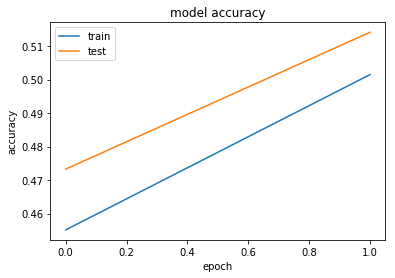

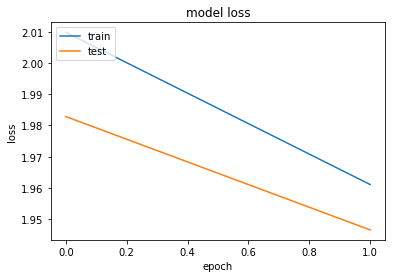

In [161]:
model_rnncnn2.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

history_rnncnn2 = model_rnncnn2.fit(X_train,
                                    y_train, 
                                    batch_size=64, 
                                    epochs=2,
#                                     validation_split=0.2,
                                    validation_data=(X_test, y_test))

loss, accuracy = model_rnncnn2.evaluate(X_train, y_train, verbose=1)

print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model_rnncnn2.evaluate(X_test, y_test, verbose=1)

print("Testing Accuracy:  {:.4f}".format(accuracy))

# list all data in history
print(history_rnncnn2.history.keys())
# summarize history for accuracy
plt.plot(history_rnncnn2.history['accuracy'])
plt.plot(history_rnncnn2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_rnncnn2.history['loss'])
plt.plot(history_rnncnn2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# <font color='red'>Hierarchical Attention Network -> IGNORE EVERYTHING BELOW FOR NOW!</font>

Make an embedding matrix

### Setting Up The Model

Setting up the layers of the model

In [ ]:
#####################################################################################################################
# define the attention layer (from https://humboldt-wi.github.io/blog/research/information_systems_1819/group5_han/)
#####################################################################################################################
"""
    Hierarchial Attention Layer as described by Hierarchical Attention Networks for Document Classification(2016)
    - Yang et. al.
    Source: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
    Theano backend
"""

class AttentionLayer(keras.layers.Layer):

    def __init__(self,attention_dim=100,return_coefficients=False,**kwargs):
        # Initializer 
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform') # initializes values with uniform distribution
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Builds all weights
        # W = Weight matrix, b = bias vector, u = context vector
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)),name='W')
        self.b = K.variable(self.init((self.attention_dim, )),name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)),name='u')
        self.trainable_weights = [self.W, self.b, self.u]

        super(AttentionLayer, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, hit, mask=None):
        # Here, the actual calculation is done
        uit = K.bias_add(K.dot(hit, self.W),self.b)
        uit = K.tanh(uit)
        
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)
        
        if mask is not None:
            ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = hit * ait
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), ait]
        else:
            return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]

In [ ]:
##################################################################################################################
# define the model layers (from https://humboldt-wi.github.io/blog/research/information_systems_1819/group5_han/)
##################################################################################################################

# Parameters
MAX_SENTENCE_NUM = 30
MAX_WORD_NUM = 40
MAX_FEATURES = vocab_len

# Words level attention model
word_input = Input(shape=(MAX_WORD_NUM,), dtype='int32',name='word_input')
word_sequences = embedding_layer(word_input)
word_gru = Bidirectional(GRU(50, return_sequences=True),name='word_gru')(word_sequences)
word_dense = Dense(100, activation='relu', name='word_dense')(word_gru) 
word_att,word_coeffs = AttentionLayer(EMBED_SIZE,True,name='word_attention')(word_dense)
wordEncoder = Model(inputs = word_input,outputs = word_att)

# Sentence level attention model
sent_input = Input(shape=(MAX_SENTENCE_NUM,MAX_WORD_NUM), dtype='int32',name='sent_input')
sent_encoder = TimeDistributed(wordEncoder,name='sent_linking')(sent_input)
sent_gru = Bidirectional(GRU(50, return_sequences=True),name='sent_gru')(sent_encoder)
sent_dense = Dense(100, activation='relu', name='sent_dense')(sent_gru) 
sent_att,sent_coeffs = AttentionLayer(EMBED_SIZE,return_coefficients=True,name='sent_attention')(sent_dense)
sent_drop = Dropout(0.5,name='sent_dropout')(sent_att)
preds = Dense(5, activation='softmax',name='output')(sent_drop)

In [ ]:
# compile model
model = Model(sent_input, preds)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
print(wordEncoder.summary())
print(model.summary())

In [ ]:
# train the model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=7, batch_size=32)

### Use Word2Vec For Embeddings

In [17]:
# turn the lyrics into a list of sentences (assuming each line is the equivilent of a sentence)

# create a blank list
result = []

# loop through every lyric
for i in tqdm(lyr_list):
    tmp = []
    
    # if the entry is a newline indicator, remove it and start a new list tmp
    for entry in i:
        if entry != '\n ':
            tmp.append(entry)
        else:
            result.append(tmp)
            tmp = []
    result.append(tmp)

result

C:\Users\blitz\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


[['think', 'hear', 'voice', 'yesterday'],
 ['when', 'turn', 'around', 'to', 'say'],
 ['that', 'love', 'baby'],
 ['realize', 'be', 'just', 'mind'],
 ['play', 'trick', 'on'],
 ['and', 'seem', 'cold', 'lately', 'at', 'night'],
 ['and', 'try', 'to', 'sleep', 'with', 'the', 'light', 'on'],
 ['every', 'time', 'the', 'phone', 'ring'],
 ['pray', 'to', 'God', 'be'],
 ['and', 'just', 'can', 'not', 'believe'],
 ['that', 'be', 'through'],
 ['miss'],
 ['there', 'be', 'no', 'other', 'way', 'to', 'say'],
 ['and', 'can', 'not', 'deny'],
 ['miss'],
 ['be', 'so', 'easy', 'to', 'see'],
 ['miss', 'and'],
 ['be', 'turn', 'over', 'this', 'time'],
 ['have', 'really', 'change', 'mind', 'about', 'each', 'other', "'s", 'love'],
 ['all', 'the', 'feeling', 'that', 'use', 'to', 'share'],
 ['refuse', 'to', 'believe'],
 ['that', 'do', 'not', 'care'],
 ['miss'],
 ['there', 'be', 'no', 'other', 'way', 'to', 'say'],
 ['and', 'and', 'can', 'not', 'deny'],
 ['miss'],
 ['be', 'so', 'easy', 'to', 'see'],
 ['miss', 'and'],


In [18]:
result2 = []

# loop through every line, pulling the index and the actual list
for index, value in tqdm(enumerate(result)):

    # lowercase everyhing and turn into a string
    temp_lower = [x.lower() for x in value]
    temp = " ".join(temp_lower)
    
    # skip the line if it is a verse indicator
    if re.search(r"verse [1-9]", temp):
        continue
        
    # remove any song markers from the data (these are single item lists with values that indicate song parts)
    if temp != 'chorus' and temp != 'intro' and temp != 'outro hook' and temp != 'bridge' and temp != 'pre hook' and temp != 'hook':
        result2.append(temp_lower)

C:\Users\blitz\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [19]:
result2[0]

['think', 'hear', 'voice', 'yesterday']

In [20]:
# create the word2vec model based on the lyrics corpus
w2v_model = gensim.models.Word2Vec(result2, min_count=5, workers=4, size=100)

In [21]:
# test a value to see the vector
w2v_model['yesterday']

C:\Users\blitz\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([ 4.3283772e-01,  1.4335864e+00, -1.7664821e+00,  4.3703961e-01,
        1.3191137e+00,  1.8975000e+00,  1.1984626e+00, -4.1129452e-01,
        6.8580699e-01, -3.6758894e-01, -6.0178936e-01,  6.2423676e-01,
       -9.7002947e-01,  1.2917686e+00, -1.1202073e+00, -2.9131788e-01,
       -3.4717828e-01, -5.7396936e-01,  1.4871296e-01, -7.2570139e-01,
       -1.1832834e-01, -6.9199044e-01,  6.3340080e-01,  7.0754057e-01,
       -4.1724154e-01, -4.1730311e-02, -6.9686675e-01, -1.1093780e+00,
        4.4056216e-01,  1.3571025e+00, -1.5729825e-01, -1.9833639e-01,
       -1.6182265e+00, -3.8581944e-01,  6.5323168e-01, -2.5185885e-02,
       -3.9590884e-02, -1.1690814e-01,  2.5967041e-01,  6.6333759e-01,
       -3.3900586e-01,  5.2886319e-01, -1.0311929e+00,  2.3941720e-01,
        5.7621361e-03,  4.5912898e-01,  4.3914855e-01,  2.1193602e+00,
       -1.3468895e+00,  7.1861601e-01, -1.0856527e+00, -7.6050991e-01,
        1.6328982e-03, -2.5321501e-01, -7.2204876e-01, -7.7476412e-01,
      

In [22]:
# number of words in the vocab
vocab_len = len(w2v_model.wv.vocab)
vocab_len

35539